In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # to separate pages based on language (regular expression)
import matplotlib.pyplot as plt # to visualize data
from pandas.plotting import autocorrelation_plot # to visualize and configure the parameters of ARIMA model
from statsmodels.tsa.arima_model import ARIMA # to make an ARIMA model that fits the data

In [2]:
url = "C:\\Users\\neelu\\Desktop\\web traffic forecasting\\data\\train_1.csv"
train_df = pd.read_csv(url).fillna(0)
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

train_df['lang'] = train_df.Page.map(find_language)

In [5]:
lang_sets = {}
lang_sets['en'] = train_df[train_df.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_df[train_df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_df[train_df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_df[train_df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_df[train_df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_df[train_df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_df[train_df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_df[train_df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

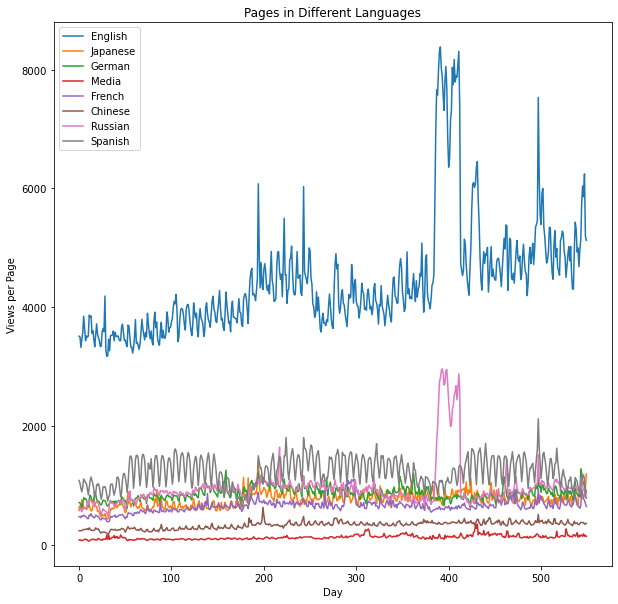

In [6]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
        
for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

en


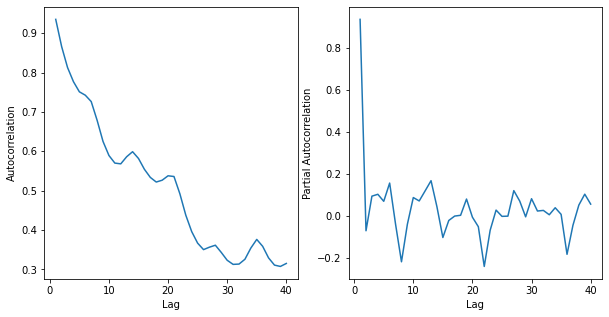

ja


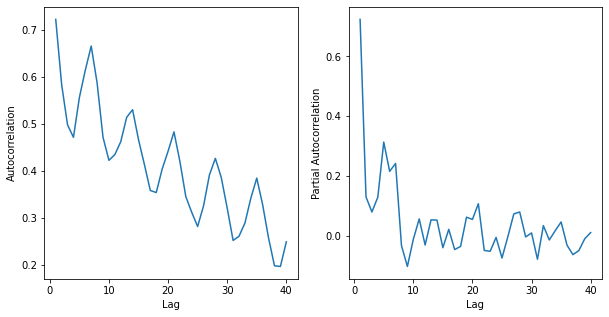

de


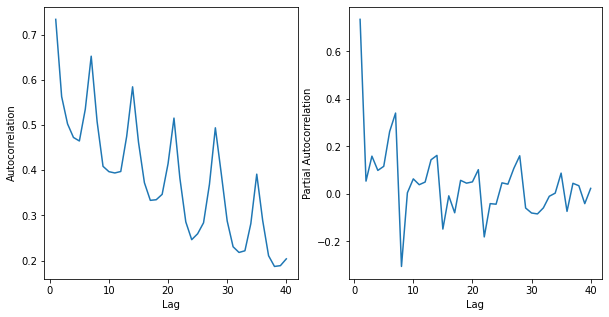

na


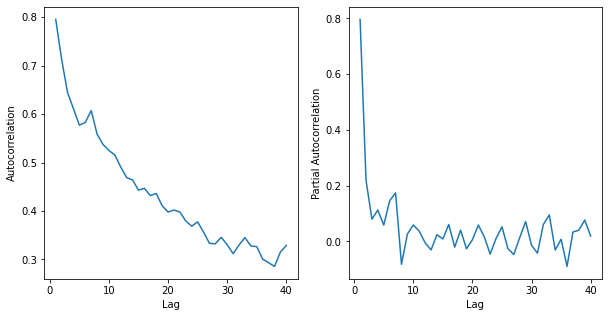

fr


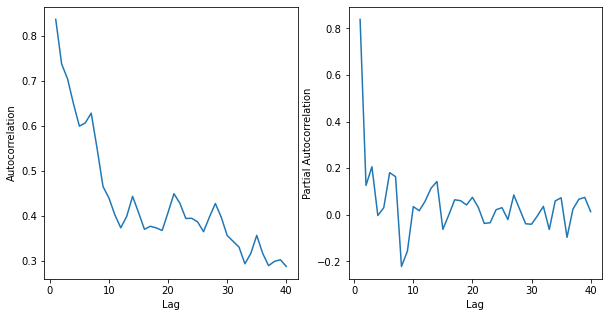

zh


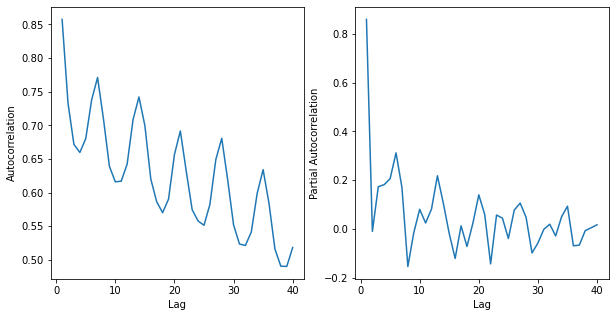

ru


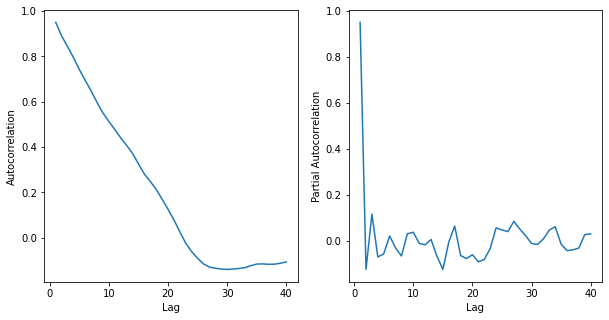

es


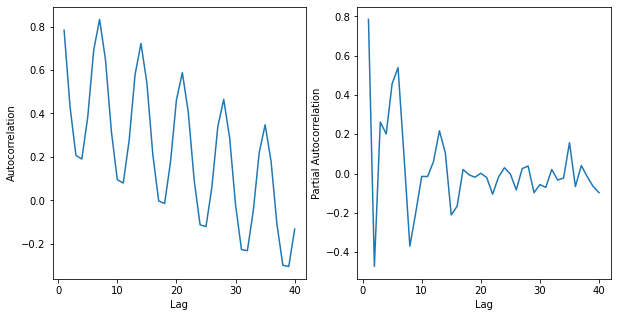

In [48]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

warnings.filterwarnings('ignore')

en


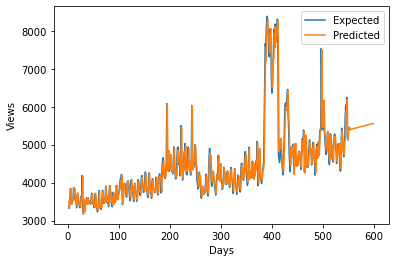

ja


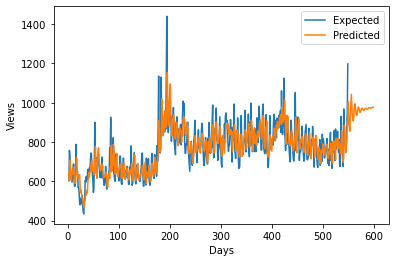

de


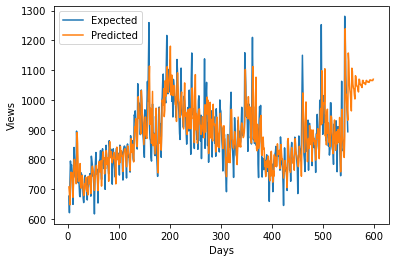

na


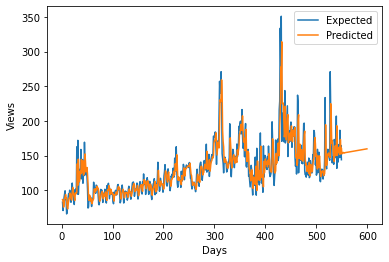

fr


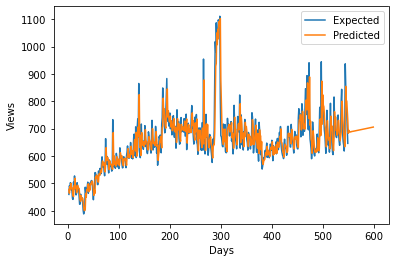

zh


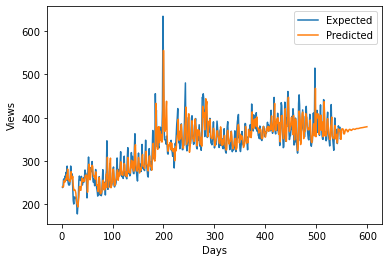

ru


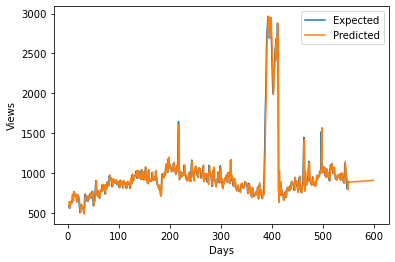

es


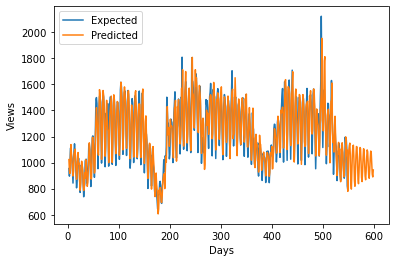

In [8]:
import math

f = open("C:\\Users\\neelu\\Desktop\\web traffic forecasting\\model\\ARIMA_hits.txt","w")

list_of_column_names = list(train_df.columns)
list_of_column_names.remove('Page')

params = {'en': [4,1,0], 'ja': [7,1,1], 'de': [7,1,1], 'na': [4,1,0], 'fr': [4,1,0], 'zh': [7,1,1], 'ru': [4,1,0], 'es': [7,1,1]}

lang_obj = {'en':'English','ja':'Japanese','de':'German','na':'Media','fr':'French','zh':'Chinese','ru':'Russian','es':'Spanish'}

for key in sums:
    
    print(key)
    
    for keys in lang_obj:
        if(keys == key):
            f.write(lang_obj[keys])
            f.write("\n")
    
    data = np.array(sums[key])
    f.write("Date         Expected         Predicted         Error")
    f.write("\n")
    
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    pred = result.predict(2,599,typ='levels')
    
    x = [i for i in range(600)]
    i=0
    for i in range(len(data)):
        f.write(str(list_of_column_names[i]) + "     " + str(math.ceil(data[i])) + "               " + str(math.ceil(pred[i])) +"           "+ str(np.sqrt(np.mean((math.ceil(data[i]) - math.ceil(pred[i])) ** 2))))
        f.write("\n")

    plt.plot(x[2:len(data)],data[2:] ,label='Expected')
    plt.plot(x[2:],pred,label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    

warnings.filterwarnings('ignore')


In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean
from sklearn.metrics import accuracy_score

for key in sums:
    data = np.array(sums[key])
    
    result = None
    arima = ARIMA(data,params[key])
    result = arima.fit(disp=False)
    pred = result.predict(2,599,typ='levels')
    
    expected = []
    predictions = []

    for i in range(len(data)):
        predictions.append(pred[i]/1000)
        expected.append(data[i]/1000)
    
    bias = []
    mae = []
    mse = []
    rmseArr = []
    mape = []

    forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
    
    bias.append(sum(forecast_errors) * 1.0/len(expected))
    
    mae.append(mean_absolute_error(expected, predictions))
    
    mse.append(mean_squared_error(expected, predictions))
    
    mse_err = mean_squared_error(expected, predictions)
    rmseArr.append(sqrt(mse_err))
    
    y_true, y_pred = np.array(expected), np.array(predictions)
    mape.append(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
               
print('Bias: %f' % mean(bias))
print('MAE: %f' % mean(mae))
print('MSE: %f' % mean(mse))
print('RMSE: %f' % mean(rmseArr))
print('MAPE: %f' % mean(mape))

Bias: 0.000204
MAE: 0.188291
MSE: 0.054247
RMSE: 0.232909
MAPE: 15.704892


In [170]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [10]:
train_df = train_df.drop('Page',axis = 1)
train_df.shape

(145063, 551)

In [11]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

en


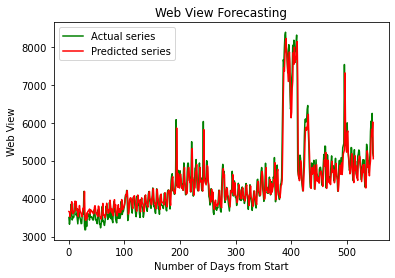

ja


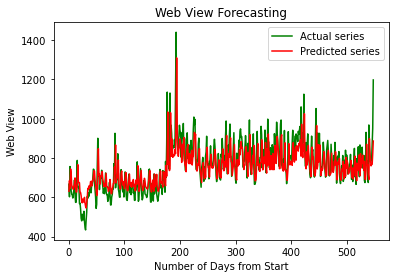

de


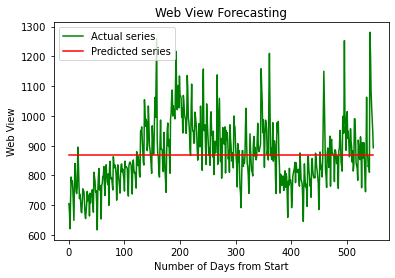

na


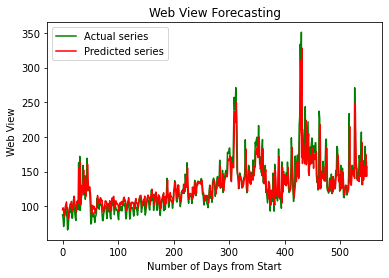

fr


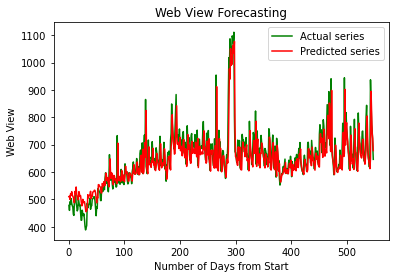

zh


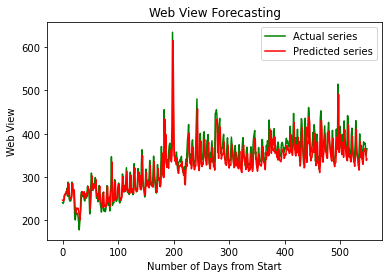

ru


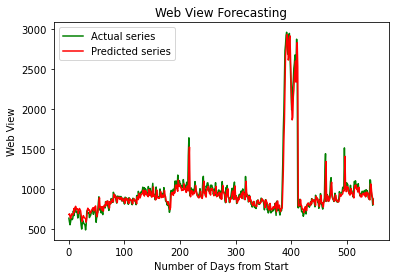

es


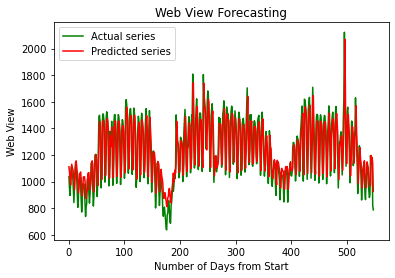

Bias: 0.005630
MAE: 0.081141
MSE: 0.022407
RMSE: 0.114938
MAPE: 7.862425


In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean
from sklearn.metrics import accuracy_score
import numpy as np

bias = []
mae = []
mse = []
rmseArr = []
mape = []

for key in sums:
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]


    #Using Data From Random Row for Training and Testing

    X = row[0:549]
    y = row[1:550]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)


    #Training LSTM

    #Reshaping Array
    X_train = np.reshape(X_train, (384,1,1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

    # Getting the predicted Web View
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
    inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)

    print(key)
    
#     expected = y
#     predictions = b
#     forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
#     print('Forecast Errors: %s' % forecast_errors)
    # expected = y
    # predictions = y_pred
    # mse = mean_squared_error(expected, predictions)
    # rmse = sqrt(mse)
    # print('Performance ',  int(rmse * 0.1), "%")
    
    # error = ((abs(pred_value - original_value)) / original_value) * 100
    # error_list.append(error)

    # Visualising Result
    plt.figure
    plt.plot(y, color = 'green', label = 'Actual series')
    plt.plot(y_pred, color = 'red', label = 'Predicted series')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()
    
    
    b = np.reshape(y_pred, (np.product(y_pred.shape),))
    
    expected = []
    predictions = []
    
    for i in range(len(y)):
        predictions.append(b[i]/1000)
        expected.append(y[i]/1000)

    forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
    
    bias.append(sum(forecast_errors) * 1.0/len(expected))
    
    mae.append(mean_absolute_error(expected, predictions))
    
    mse.append(mean_squared_error(expected, predictions))
    
    mse_err = mean_squared_error(expected, predictions)
    rmseArr.append(sqrt(mse_err))
    
    y_true, y_pred = np.array(expected), np.array(predictions)
    mape.append(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    

warnings.filterwarnings('ignore')

print('Bias: %f' % mean(bias))
print('MAE: %f' % mean(mae))
print('MSE: %f' % mean(mse))
print('RMSE: %f' % mean(rmseArr))
print('MAPE: %f' % mean(mape))